# EDA

### 0. 탐색할 내용
1. train 데이터의 전체적 특성 파악
    - klue/bert-base tokenizer 사용한 토큰 분석
        - 기사제목 길이 분포
        - unknown 토큰 비율
        - 노이즈에 따른 토큰화 영향 분석
    - Label 분포 확인: 수치, 시각화
    - true label mapping 대략 확인
    - 노이즈 데이터와 정상 데이터 분리 분석
    - 노이즈 종류/분포/정도 확인 -> 노이즈 처리 전략 수립
2. 데이터 품질 측정 metric 수립
    - 데이터의 전반적 품질: `Great Expectations` 라이브러리 고려
    - 노이즈 평가: perplexity, 
    - 라벨 품질 평가: cleanlab, LLM 평가 앙상블
3. 신뢰할 수 있는 validation set 수립

### Set Hyperparameters

In [28]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

from collections import Counter

In [ ]:
SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_name = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 1. Train 데이터의 전체적 특성 파악

In [ ]:
data = pd.read_csv('../../data/train.csv')
data

,ID,text,target
0,ynat-v1_train_00000,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,4
1,ynat-v1_train_00001,K찰.국DLwo 로L3한N% 회장 2 T0&}송=,3
2,ynat-v1_train_00002,"m 김정) 자주통일 새,?r열1나가야1보",2
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5
4,ynat-v1_train_00004,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,6
...,...,...,...
2795,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,6
2796,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,2
2797,ynat-v1_train_02797,텔레그램+한D 등h亞서 2시간H다운…C버T정gf39종!2보,4
2798,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,1


#### 1-1. `klue/bert-base` 토크나이저를 활용한 text 분석

In [ ]:
# 토큰화된 텍스트와 길이 계산
texts = data.text.tolist()
texts_tokenized = [tokenizer.tokenize(text, truncation=False) for text in texts]
texts_len = [len(tokens) for tokens in texts_tokenized]
length_average = sum(texts_len)/len(texts_len)

# Unknown 토큰 개수와 비율 계산
unk_token = tokenizer.unk_token  # unknown 토큰: '[UNK]'
unk_counts = [tokens.count(unk_token) for tokens in texts_tokenized]  # 각 문장의 unknown 토큰 개수
unk_ratios = [count / len(tokens) if len(tokens) > 0 else 0 for count, tokens in zip(unk_counts, texts_tokenized)]  # 비율 계산
avg_unk_ratio = np.mean(unk_ratios) # 전체 텍스트의 평균 unknown 토큰 비율

# 디코딩 ([CLS]와 [SEP] 토큰은 제외)
texts_decoded = []
for tokens in texts_tokenized:
    filtered_tokens = [token for token in tokens if token != tokenizer.cls_token and token != tokenizer.sep_token]
    token_ids = tokenizer.convert_tokens_to_ids(filtered_tokens)
    decoded_text = tokenizer.decode(token_ids, skip_special_tokens=False)
    texts_decoded.append(decoded_text)

# 결과 출력
print("평균 문장 길이:", length_average)
print("Unknown 토큰 비율:", avg_unk_ratio)

평균 문장 길이: 17.412142857142857
Unknown 토큰 비율: 0.0038783693481098413
Denoised 결과 예시: ['정i : 파1 미사z KT ( 이용기간 2e 단 ] Q분종U2보', 'K찰. 국DLwo 로L3한N % 회장 2 T0 & } 송 =', 'm 김정 ) 자주통일 새,? r열1나가야1보', '갤노트8 주말 27만대 개통 … 시장은 불법 보조금 얼룩', 'pI 美 대선I앞두고 R2fr단 발 ] $ 비해 감시 강화']


In [45]:
print(max(texts_len))
print(min(texts_len))

35
3


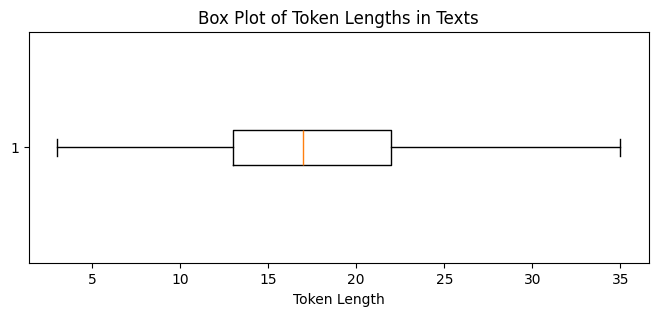

In [48]:
import matplotlib.pyplot as plt

# Box plot 그리기
plt.figure(figsize=(8, 3))
plt.boxplot(texts_len, vert=False)
plt.xlabel("Token Length")
plt.title("Box Plot of Token Lengths in Texts")
plt.show()

In [41]:
tokenized_text = pd.DataFrame({'text': texts,
                               'text_encode': texts_tokenized,
                               'text_decode': texts_decoded,
                               'length': texts_len,
                               'unk_cnt': unk_counts,
                               'unk_ratio': unk_ratios})
tokenized_text

,text,text_encode,text_decode,length,unk_cnt,unk_ratio
0,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,"[정, ##i, :, 파, ##1, 미사, ##z, KT, (, 이용, ##기, #...",정i : 파1 미사z KT ( 이용기간 2e 단 ] Q분종U2보,22,0,0.00
1,K찰.국DLwo 로L3한N% 회장 2 T0&}송=,"[K, ##찰, ., 국, ##D, ##L, ##wo, 로, ##L, ##3, ##...",K찰. 국DLwo 로L3한N % 회장 2 T0 & } 송 =,21,0,0.00
2,"m 김정) 자주통일 새,?r열1나가야1보","[m, 김정, ), 자주, ##통일, 새, ,, ?, r, ##열, ##1, ##나...","m 김정 ) 자주통일 새,? r열1나가야1보",15,0,0.00
3,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,"[갤, ##노, ##트, ##8, 주말, 27, ##만, ##대, 개통, …, 시장...",갤노트8 주말 27만대 개통 … 시장은 불법 보조금 얼룩,15,0,0.00
4,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,"[p, ##I, 美, 대선, ##I, ##앞, ##두고, R, ##2, ##f, #...",pI 美 대선I앞두고 R2fr단 발 ] $ 비해 감시 강화,18,0,0.00
...,...,...,...,...,...,...
2795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,"[트럼프, 폭스, ##뉴스, 앵커, ##들, 충성, ##도, 점수, ##매, ##겨...",트럼프 폭스뉴스 앵커들 충성도 점수매겨 … 10점만점에 12점도,19,0,0.00
2796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,"[삼성, 갤럭시, ##S, ##9, 정식, 출시, 첫, 주말, 이통, ##시장, 잠잠]",삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,11,0,0.00
2797,텔레그램+한D 등h亞서 2시간H다운…C버T정gf39종!2보,"[텔레, ##그램, +, 한, ##D, 등, ##h, [UNK], 서, 2, ##시...",텔레그램 + 한D 등h [UNK] 서 2시간H다운 … C버T정gf39종! 2보,25,1,0.04
2798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,"[인터뷰, 류현진, 친구, ##에, ##게, 안타, 맞, ##는, 것, 싫어, ##...",인터뷰 류현진 친구에게 안타 맞는 것 싫어해 … 승부는 냉정,15,0,0.00


In [47]:
tokenized_text[tokenized_text.length < 5]

,text,text_encode,text_decode,length,unk_cnt,unk_ratio
1151,백두대간의 가을 하늘,"[백두대간, ##의, 가을, 하늘]",백두대간의 가을 하늘,4,0,0.0
1810,아름다운 금강 둘레길,"[아름다운, 금강, 둘레길]",아름다운 금강 둘레길,3,0,0.0
1824,폭염엔 역시 얼음,"[폭염, ##엔, 역시, 얼음]",폭염엔 역시 얼음,4,0,0.0
1994,미세먼지 싫어N,"[미세먼지, 싫어, ##N]",미세먼지 싫어N,3,0,0.0
2149,정선 산불 진화 안간힘,"[정선, 산불, 진화, 안간힘]",정선 산불 진화 안간힘,4,0,0.0
2357,코스피 하락 마감,"[코스피, 하락, 마감]",코스피 하락 마감,3,0,0.0


In [54]:
pd.set_option('display.max_colwidth', None)

In [ ]:
idx = 190
tokenized_text[tokenized_text.unk_cnt > 0].iloc[idx:idx+10]

# 인식 못하는 [UNK] 토큰들 리스트
# 아퀼라
# ↓, ↔, p↓ (금리 3.2%p↓)
# \
# 阿, 印, 伊, 亞, 檢, 崔, 丁, 展, 企
# 출마금cyj슈9웡
# KT텔레캅
# 삑
# 소듐고속5
# 쌩쌩
# 아r널R벵거
# G펭귄의x사생U
# 갭투자
# 황포돛배
# 잰걸음
# 1⅔이닝
# 보관하ogf쭐종합2보
# 안tH팜한NT닻
# 펭수
# 셧다q에
# 챗봇
# 뎀s레N

,text,text_encode,text_decode,length,unk_cnt,unk_ratio
2681,추신(c이VUr 야구에 인생a\# 선수…9내 낼 수 $어,"[추신, (, c, ##이, ##V, ##U, ##r, 야구, ##에, 인생, ##a, [UNK], #, 선수, …, 9, ##내, 낼, 수, $, 어]",추신 ( c이VUr 야구에 인생a [UNK] # 선수 … 9내 낼 수 $ 어,21,1,0.047619
2715,"중Z재해기""처벌"" 제정 촉구하는Ia정규V\이제그만 U원들","[중, ##Z, ##재해, ##기, "", 처벌, "", 제정, 촉구, ##하, ##는, ##I, ##a, ##정, ##규, ##V, [UNK], 이제, ##그, ##만, U, ##원, ##들]","중Z재해기 "" 처벌 "" 제정 촉구하는Ia정규V [UNK] 이제그만 U원들",23,1,0.043478
2750,쿠Xi·코스w·뎀s레N=R하는R축D스타들R나@이적시켜3,"[쿠, ##X, ##i, ·, 코스, ##w, ·, [UNK], =, R, ##하, ##는, ##R, ##축, ##D, ##스타, ##들, ##R, ##나, @, 이적, ##시, ##켜, ##3]",쿠Xi · 코스w · [UNK] = R하는R축D스타들R나 @ 이적시켜3,24,1,0.041667
2766,"Q산U 림자금\ I,SC다…Y감원장 b합YM시스템_구6","[Q, ##산, ##U, 림, ##자, ##금, [UNK], I, ,, SC, ##다, …, Y, ##감, ##원장, b, ##합, ##Y, ##M, ##시스, ##템, _, 구, ##6]","Q산U 림자금 [UNK] I, SC다 … Y감원장 b합YM시스템 _ 구6",24,1,0.041667
2773,"*@이RAO _zW첫 스3#U 메\트,20…최고 1L(Y원OV출}","[*, @, 이, ##RA, ##O, _, z, ##W, ##첫, 스, ##3, #, U, 메, [UNK], 트, ,, 20, …, 최고, 1, ##L, (, Y, ##원, ##O, ##V, ##출, }]","* @ 이RAO _ zW첫 스3 # U 메 [UNK] 트, 20 … 최고 1L ( Y원OV출 }",29,1,0.034483
2774,문답으0`#어=mX거*지T로드맵 n\내#]C,"[문답, ##으, ##0, `, #, 어, =, m, ##X, ##거, *, 지, ##T, ##로드, ##맵, n, [UNK], 내, #, ], C]",문답으0 ` # 어 = mX거 * 지T로드맵 n [UNK] 내 # ] C,21,1,0.047619
2775,PD호Gx동y와5서면합의로\ %]t}제 u정안 발의,"[PD, ##호, ##G, ##x, ##동, ##y, ##와, ##5, ##서, ##면, ##합, ##의, ##로, [UNK], %, ], t, }, 제, u, ##정, ##안, 발의]",PD호Gx동y와5서면합의로 [UNK] % ] t } 제 u정안 발의,23,1,0.043478
2797,텔레그램+한D 등h亞서 2시간H다운…C버T정gf39종!2보,"[텔레, ##그램, +, 한, ##D, 등, ##h, [UNK], 서, 2, ##시간, ##H, ##다운, …, C, ##버, ##T, ##정, ##g, ##f, ##39, ##종, !, 2, ##보]",텔레그램 + 한D 등h [UNK] 서 2시간H다운 … C버T정gf39종! 2보,25,1,0.040000


### 1-2. Label 분포 확인

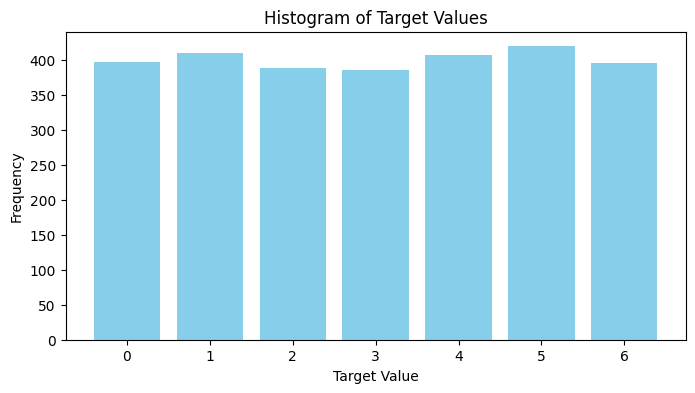

In [52]:
# 각 target 값의 빈도수 계산
target_counts = data['target'].value_counts().sort_index()

# 히스토그램 그리기
plt.figure(figsize=(8, 4))
plt.bar(target_counts.index, target_counts.values, color='skyblue')
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.xticks(range(7))  # x축의 값은 0부터 6까지
plt.show()

### 1-3. 노이즈 정도 확인
1. 형태소 분석 이용
    - 한국어 형태소 분석기를 사용하여 각 제목을 분석하고, 인식되지 않는 토큰의 비율을 계산
    - 인식되지 않는 토큰 비율 높을수록 노이즈 많을 것
2. 문자 수준 엔트로피
    - 제목의 문자 수준 엔트로피 계산
    - 일반적인 한국어 뉴스 제목보다 엔트로피가 높다면 노이즈가 많을 것
3. 언어 모델 기반 접근
    - 대규모 한국어 뉴스 제목 코퍼스로 학습된 언어 모델을 사용하여 각 제목의 perplexity를 계산
    - Perplexity가 높을수록 노이즈가 많다고 볼 수 있음

##### 1. 형태소 분석기 이용

In [82]:
# !pip install konlpy
# !apt-get install default-jdk

from konlpy.tag import Okt
import re

okt = Okt()

In [93]:
# 유의미한 문자 세트 (한글, 영어, 숫자)
valid_chars = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789가-힣')

# 노이즈를 판단하는 함수
def measure_noise(text):
    morphs = okt.morphs(text)
    noise_count = 0
    total_count = len(morphs)

    # for morph in morphs:
    #     # 노이즈 판단 기준 (형태소의 길이/ 불필요한 문자 포함 여부)
    #     if len(morph) < 3 or any(char not in valid_chars for char in morph):
    #         noise_count += 1
    
    for morph in morphs:
        # 노이즈 판단 기준 수정
        if len(morph) == 1 and not morph.isalnum():
            noise_count += 1
        elif len(morph) >= 2 and any(char not in valid_chars for char in morph):
            noise_count += 1

    noise_ratio = noise_count / total_count if total_count > 0 else 0
    return noise_ratio, noise_count, total_count

In [95]:
normal_data = ['갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩',
               '美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다',
               '아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...',
               '朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합',
               '듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감']
noise_data = ['정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보',
              'K찰.국DLwo 로L3한N% 회장 2 T0&}송=',
              'm 김정) 자주통일 새,?r열1나가야1보',
              'pI美대선I앞두고 R2fr단 발] $비해 감시 강화',
              '프로야구~롯TKIAs광주 경기 y천취소']

# 노이즈 비율 측정
for text in normal_data:
    noise_ratio, noise_count, total_count = measure_noise(text)
    print(f"텍스트: '{text}'")
    print(f"총 형태소 수: {total_count}, 노이즈 형태소 수: {noise_count}, 노이즈 비율: {noise_ratio:.2%}\n")
print("-"*100)
for text in noise_data:
    noise_ratio, noise_count, total_count = measure_noise(text)
    print(f"텍스트: '{text}'")
    print(f"총 형태소 수: {total_count}, 노이즈 형태소 수: {noise_count}, 노이즈 비율: {noise_ratio:.2%}\n")


### 기준 세우기 모호함.... 명확히 구분 잘 안됨...

텍스트: '갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩'
총 형태소 수: 13, 노이즈 형태소 수: 9, 노이즈 비율: 69.23%

텍스트: '美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다'
총 형태소 수: 14, 노이즈 형태소 수: 7, 노이즈 비율: 50.00%

텍스트: '아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...'
총 형태소 수: 15, 노이즈 형태소 수: 8, 노이즈 비율: 53.33%

텍스트: '朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합'
총 형태소 수: 11, 노이즈 형태소 수: 10, 노이즈 비율: 90.91%

텍스트: '듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감'
총 형태소 수: 11, 노이즈 형태소 수: 8, 노이즈 비율: 72.73%

----------------------------------------------------------------------------------------------------
텍스트: '정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보'
총 형태소 수: 20, 노이즈 형태소 수: 6, 노이즈 비율: 30.00%

텍스트: 'K찰.국DLwo 로L3한N% 회장 2 T0&}송='
총 형태소 수: 18, 노이즈 형태소 수: 5, 노이즈 비율: 27.78%

텍스트: 'm 김정) 자주통일 새,?r열1나가야1보'
총 형태소 수: 13, 노이즈 형태소 수: 6, 노이즈 비율: 46.15%

텍스트: 'pI美대선I앞두고 R2fr단 발] $비해 감시 강화'
총 형태소 수: 15, 노이즈 형태소 수: 7, 노이즈 비율: 46.67%

텍스트: '프로야구~롯TKIAs광주 경기 y천취소'
총 형태소 수: 9, 노이즈 형태소 수: 5, 노이즈 비율: 55.56%



##### 2. 문자 수준 엔트로피 이용

In [97]:
import math
from collections import Counter
from konlpy.tag import Okt

def calculate_entropy(text):
    # 문자 빈도 계산
    char_freq = Counter(text)
    total_chars = len(text)
    
    # 엔트로피 계산
    entropy = 0
    for char, freq in char_freq.items():
        prob = freq / total_chars
        entropy -= prob * math.log2(prob)
    
    return entropy

def calculate_conditional_entropy(text):
    okt = Okt()
    morphs = okt.morphs(text)
    
    # 형태소 빈도 계산
    morph_freq = Counter(morphs)
    total_morphs = len(morphs)
    
    # 조건부 엔트로피 계산
    cond_entropy = 0
    for morph, freq in morph_freq.items():
        prob = freq / total_morphs
        cond_entropy -= prob * math.log2(prob)
    
    return cond_entropy

def calculate_noise_ratio(text):
    char_entropy = calculate_entropy(text)
    morph_entropy = calculate_conditional_entropy(text)
    
    # 노이즈 비율 계산 (문자 엔트로피와 형태소 엔트로피의 차이)
    noise_ratio = (char_entropy - morph_entropy) / char_entropy
    
    return noise_ratio

# 테스트
normal_data = ['갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩',
               '美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다',
               '아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...',
               '朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합',
               '듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감']
noise_data = ['정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보',
              'K찰.국DLwo 로L3한N% 회장 2 T0&}송=',
              'm 김정) 자주통일 새,?r열1나가야1보',
              'pI美대선I앞두고 R2fr단 발] $비해 감시 강화',
              '프로야구~롯TKIAs광주 경기 y천취소']

for title in normal_data:
    noise_ratio = calculate_noise_ratio(title)
    print(f"제목: {title}")
    print(f"노이즈 비율: {noise_ratio:.4f}")
    print()
print('-'*100)
for title in noise_data:
    noise_ratio = calculate_noise_ratio(title)
    print(f"제목: {title}")
    print(f"노이즈 비율: {noise_ratio:.4f}")
    print()

제목: 갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩
노이즈 비율: 0.1440

제목: 美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다
노이즈 비율: 0.0418

제목: 아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...
노이즈 비율: 0.0998

제목: 朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합
노이즈 비율: 0.2346

제목: 듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감
노이즈 비율: 0.1401

----------------------------------------------------------------------------------------------------
제목: 정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보
노이즈 비율: 0.0235

제목: K찰.국DLwo 로L3한N% 회장 2 T0&}송=
노이즈 비율: 0.0489

제목: m 김정) 자주통일 새,?r열1나가야1보
노이즈 비율: 0.1459

제목: pI美대선I앞두고 R2fr단 발] $비해 감시 강화
노이즈 비율: 0.0959

제목: 프로야구~롯TKIAs광주 경기 y천취소
노이즈 비율: 0.2623



In [ ]:
# from konlpy.tag import Okt
# import re
# from collections import Counter
# import math
# import numpy as np

# okt = Okt()

# def calculate_noise_ratio(text):
#     # 1. 형태소 분석
#     morphs = okt.morphs(text)
    
#     # 2. 특수 문자 및 비정상적 패턴 검출
#     special_chars = re.findall(r'[^가-힣a-zA-Z0-9\s]', text)
#     special_char_ratio = len(special_chars) / len(text)
    
#     # 3. 형태소 기반 엔트로피 계산
#     morph_freq = Counter(morphs)
#     morph_entropy = 0
#     for morph, freq in morph_freq.items():
#         prob = freq / len(morphs)
#         morph_entropy -= prob * math.log2(prob)
    
#     # 4. 단어 길이의 변동성 계산
#     word_lengths = [len(word) for word in okt.nouns(text)]
#     length_variance = np.var(word_lengths) if word_lengths else 0
    
#     # 5. 노이즈 비율 계산 (가중치 적용)
#     noise_ratio = (0.4 * morph_entropy + 0.4 * special_char_ratio + 0.2 * length_variance)
    
#     return noise_ratio

# # 테스트
# normal_titles = [
#     "갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩",
#     "美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다",
#     "아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...",
#     "朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합",
#     "듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감"
# ]

# noise_titles = [
#     "정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보",
#     "K찰.국DLwo 로L3한N% 회장 2 T0&}송=",
#     "m 김정) 자주통일 새,?r열1나가야1보",
#     "pI美대선I앞두고 R2fr단 발] $비해 감시 강화",
#     "프로야구~롯TKIAs광주 경기 y천취소"
# ]

# print("Normal Titles:")
# for title in normal_titles:
#     print(f"{title}: {calculate_noise_ratio(title):.4f}")

# print("\nNoise Titles:")
# for title in noise_titles:
#     print(f"{title}: {calculate_noise_ratio(title):.4f}")

Normal Titles:
갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩: 1.5185
美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다: 1.6465
아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...: 1.7628
朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합: 1.4513
듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감: 1.5078

Noise Titles:
정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보: 1.8324
K찰.국DLwo 로L3한N% 회장 2 T0&}송=: 1.7740
m 김정) 자주통일 새,?r열1나가야1보: 1.5711
pI美대선I앞두고 R2fr단 발] $비해 감시 강화: 1.6536
프로야구~롯TKIAs광주 경기 y천취소: 1.4790


In [140]:
# ## 한국어 특성을 고려한 규칙
# - 한글 자모 분리 현상 감지
# - 불규칙한 대소문자 변경 감지
# - 1글자 단어 수 계산 (한국어에서는 1글자 단어가 많으면 노이즈일 가능성이 높습니다)

# pip install spacy
# python -m spacy download ko_core_news_sm
import spacy
import string
import re

# 한국어 모델 로드
nlp = spacy.load("ko_core_news_sm")

def noise_score_spacy(text):
    doc = nlp(text)
    
    # 단어 수
    word_count = len(doc)
    
    # 노이즈 관련 점수 계산
    special_char_count = sum(1 for char in text if char in string.punctuation)
    non_korean_char_count = len(re.findall(r'[a-zA-Z0-9]', text))
    short_word_count = sum(1 for token in doc if len(token.text) == 1)
    
    # 한글 자모 분리 현상 감지
    separated_hangul_count = len(re.findall(r'[ㄱ-ㅎㅏ-ㅣ]', text))
    
    # 불규칙한 대소문자 변경 감지
    irregular_case_count = sum(1 for i in range(1, len(text)) if text[i-1].islower() and text[i].isupper())
    
    # 품사 태그 다양성 (낮을수록 노이즈 가능성 높음)
    pos_counts = {}
    for token in doc:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    pos_diversity = len(pos_counts)
    
    # 노이즈 점수 계산
    noise_score = (
        (special_char_count * 2) +
        (non_korean_char_count * 1.5) +
        (short_word_count * 1.5) +
        (separated_hangul_count * 3) +
        (irregular_case_count * 2)
    ) / max(1, word_count)  # 단어 수로 나누어 정규화
    
    # 품사 다양성에 따른 보정 (다양성이 낮을수록 점수 증가)
    diversity_factor = max(1, 5 - pos_diversity) / 5
    noise_score *= (1 + diversity_factor)
    
    # 최종 점수 범위 조정 (0-100 사이)
    final_score = min(100, max(0, noise_score * 20))
    
    return final_score

# 예시 데이터 테스트
normal_scores = [noise_score_spacy(title) for title in normal_data]
noise_scores = [noise_score_spacy(title) for title in noise_data]

print("Normal Titles Scores:", [round(score, 2) for score in normal_scores])
print("Noise Titles Scores:", [round(score, 2) for score in noise_scores])

Normal Titles Scores: [18.67, 19.64, 44.0, 4.5, 4.5]
Noise Titles Scores: [58.91, 100, 61.71, 63.0, 60.0]


In [144]:
data['noise_score'] = data['text'].apply(noise_score_spacy)

In [148]:
data[data.noise_score > 50]

,ID,text,target,noise_score
0,ynat-v1_train_00000,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,4,58.909091
1,ynat-v1_train_00001,K찰.국DLwo 로L3한N% 회장 2 T0&}송=,3,100.000000
2,ynat-v1_train_00002,"m 김정) 자주통일 새,?r열1나가야1보",2,61.714286
4,ynat-v1_train_00004,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,6,63.000000
6,ynat-v1_train_00006,프로야구~롯TKIAs광주 경기 y천취소,1,60.000000
...,...,...,...,...
2786,ynat-v1_train_02786,텅 빈 }실 선생님+홀K Y|q% T+X C1,3,79.500000
2787,ynat-v1_train_02787,13이 노바 라이n2·미J어패0 T3 10 결G상품% *,6,73.111111
2788,ynat-v1_train_02788,남원소식 춘>X학%단+장Rn 모집,0,64.800000
2792,ynat-v1_train_02792,"높`X#E율…}BO Q""[/선수 몸값 상승 CAO",1,68.727273


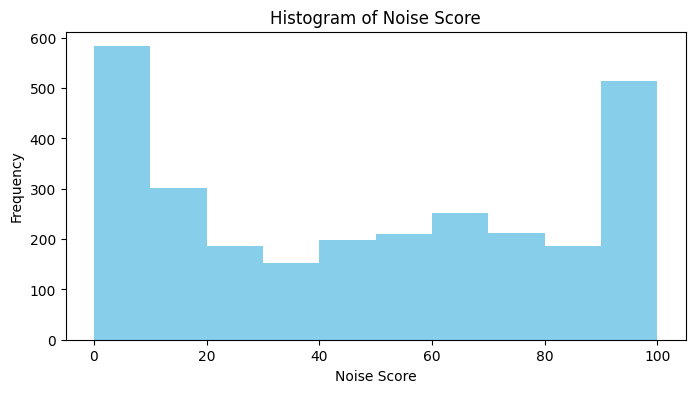

In [149]:
# 히스토그램 그리기
plt.figure(figsize=(8, 4))
plt.hist(data.noise_score, color='skyblue')
plt.xlabel("Noise Score")
plt.ylabel("Frequency")
plt.title("Histogram of Noise Score")
# plt.xticks(range(7))  # x축의 값은 0부터 6까지
plt.show()

##### 3. 언어모델 기반 접근

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# KoBERT 모델과 토크나이저 로드
model_name = "monologg/kobert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()  # 평가 모드로 설정

def calculate_naturalness_score(text):
    # 텍스트를 토큰화하고 텐서로 변환
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # CLS 토큰의 임베딩 추출
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # 첫 번째 토큰(CLS 토큰)의 출력
    
    # 점수화 (여기서는 임베딩의 L2 노름을 점수로 사용)
    score = torch.norm(cls_embedding).item()  # L2 노름을 점수로 사용
    
    return score


# Test
for title in normal_titles:
    score = calculate_naturalness_score(title)
    print(f"제목: {title}")
    print(f"자연스러움 점수: {score:.2f}")
    print()

for title in noise_titles:
    score = calculate_naturalness_score(title)
    print(f"제목: {title}")
    print(f"자연스러움 점수: {score:.2f}")
    print()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of BertForMaskedLM were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## 과제 - loss 기준으로 노이즈 식별?

### 1-4. denoising 방법
1. llm: seq2seq 모델 학습하거나 / 번역-재번역 기법 사용